**AML -ASSIGNMENT**

20 Newsgroups Dataset Assignment: Text Classification and Clustering

**Assignment Description**

1. Part 1: Text Pre-processing and Embedding Comparison (20 Points)

*   Preprocessing steps correctly implemented and explained
*   Comparison of word2vec, GloVe, and OpenAI embeddings
*   Discussion on the embeddings that provide better semantic understanding

2. Part 2: Text Classification Model (20 Points)

*   Correct implementation of chosen classification model
*   Comprehensive discussion on the choice of model, including its advantages and disadvantages

3. Part 3: Text Clustering Model (20 Points)

*   Correct implementation of chosen clustering model
*   Comprehensive discussion on the choice of model, including its pros and cons

4. Part 4: Model Evaluation (20 Points)


*   Appropriate metrics chosen and correctly used to evaluate models
*   Comprehensive discussion on the choice of metrics


5. Part 5: Model Improvement Discussion (20 Points)


*   Comprehensive discussion on potential improvements, including handling unbalanced data, dealing with slang, abbreviations or typos, and addressing context and word disambiguation challenges
Dataset Link : http://qwone.com/~jason/20Newsgroups
           20news-19997.tar.gz - Original 20 Newsgroups data set





In [1]:
import re
import os
from time import time
import requests
import tarfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# download tar file from the  location of dataset
# Loading Required Libraries
from sklearn.datasets import fetch_20newsgroups

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

**1. Part 1: Text Pre-processing and Embedding Comparison (20 Points)**


*   Preprocessing steps correctly implemented and explained
*   Comparison of word2vec, GloVe, and OpenAI embeddings
*   Discussion on the embeddings that provide better semantic understanding

**Load Data**

In [3]:
categories = ['alt.atheism', 'talk.religion.misc']
#, 'comp.graphics', 'sci.space'

data = []  # List to store the document texts
labels = []  # List to store the corresponding labels

d_train = fetch_20newsgroups(subset='train', remove = ('headers', 'footers', 'quotes'), categories=categories)
d_test = fetch_20newsgroups(subset='test', remove = ('headers', 'footers', 'quotes'), categories=categories)


In [4]:
newsgroup_train = fetch_20newsgroups(
    subset="train",
     categories=categories,
    shuffle=True,
    random_state=42,
)

newsgroup_test = fetch_20newsgroups(
    subset="test",
    categories=categories,
    shuffle=True,
    random_state=42,
)

#Create a dataframe of article and corresponding label
df_train = pd.DataFrame({'article': newsgroup_train.data, 'label': newsgroup_train.target})
df_train['article'][0]

'From: mangoe@cs.umd.edu (Charley Wingate)\nSubject: Benediktine Metaphysics\nLines: 24\n\nBenedikt Rosenau writes, with great authority:\n\n>     IF IT IS CONTRADICTORY IT CANNOT EXIST.\n\n"Contradictory" is a property of language.  If I correct this to\n\n\n      THINGS DEFINED BY CONTRADICTORY LANGUAGE DO NOT EXIST\n\nI will object to definitions as reality.  If you then amend it to\n\n      THINGS DESCRIBED BY CONTRADICTORY LANGUAGE DO NOT EXIST\n\nthen we\'ve come to something which is plainly false.  Failures in\ndescription are merely failures in description.\n\n(I\'m not an objectivist, remember.)\n\n\n-- \nC. Wingate        + "The peace of God, it is no peace,\n                  +    but strife closed in the sod.\nmangoe@cs.umd.edu +  Yet, brothers, pray for but one thing:\ntove!mangoe       +    the marv\'lous peace of God."\n'

**Remove Metadata,Header ,Footer, quotes**

Articles often contain non-relevant information such as headers, footers, metadata and quotes. By removing these elements, noise is reduced and we can focus on the core content of the articles, making it easier to analyze and extract meaningful information.Since most of the information in header footer is repetitive and it will increase the accuracy score of model by doing overfitting but model generated would be low at prediction.

Let's remove this information of header, footer and quotes before we proceed for preprocessing of main content

In [5]:
# Load the News20group dataset

newsgroup_train = fetch_20newsgroups(
    subset="train",
#     categories=categories,
    shuffle=True,
    random_state=42,
    remove=("headers", "footers", "quotes"),
)

newsgroup_test = fetch_20newsgroups(
    subset="test",
#     categories=categories,
    shuffle=True,
    random_state=42,
    remove=("headers", "footers", "quotes"),
)

#verify the names of different newsgroups in the downloaded training data
print(newsgroup_train.target_names)
print(newsgroup_train.target)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
[7 4 4 ... 3 1 8]


In [6]:
df_train = pd.DataFrame({'article': newsgroup_train.data, 'label': newsgroup_train.target})
df_train.head()

,article,label
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [7]:
df_test = pd.DataFrame({'article': newsgroup_test.data, 'label': newsgroup_test.target})
df_test.head()

,article,label
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [8]:
# Let's explore any article in train data
# Access the first article value
df_train['article'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

**Clean Function**

The clean_text function performs a series of text cleaning and preprocessing steps. Here's a breakdown of what each step does:
*   Remove Pre and Post Spaces: Strips any leading or trailing spaces from the text.
*   Lowercase the entire text: Converts the text to lowercase, ensuring consistent case throughout the text.
*   Substitute New Line Characters with Spaces: Replaces newline characters ('\n') with a space, effectively removing line breaks.
*   Tokenize the sentence: Breaks the text into individual words or tokens using a tokenization technique, likely using the word_tokenize function from the NLTK library.

Remove punctuation and special characters from each individual word:
*   Iterates over each word in the tokenized text and removes any non-alphanumeric characters, such as punctuation marks or special characters. Only alphanumeric characters are retained.

Remove stopwords and words containing fewer than 2 characters:

*   Removes common stopwords, such as "the," "is," or "and," from the text. Additionally, words with a length of less than 2 characters are filtered out.
*   WordNetLemmatizer() needs the wordnet tags (wordnet.ADJ, wordnet.VERB, wordnet.NOUN, wordnet.ADV) for each word to perform the lemmatization. We can use nltk.pos_tag() to generate the tag for each token and then write a wrapper function to convert the nltk tags into wordnet tags i.e., get_wordnet_pos (tag)
*  We have also defined a function to lemmatize each word in a tokenized text data and then return all the lemmatized tokens combined into a string:


In [9]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()

    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces
    text = re.sub(r"\n", r" ", text)

    # Tokenize the sentence
    word_tokens = word_tokenize(text)

    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))

    # Specify the stop words list
    stop_words = stopwords.words('english')

    # Remove the stopwords and words containing less then 2 characters
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word not in stop_words)]

    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)

    return text

In [10]:
### Apply cleanup to both train and test data articles
df_train['article'] = df_train['article'].apply(lambda x: clean_text(x))
df_test['article'] = df_test['article'].apply(lambda x: clean_text(x))

In [12]:
df_train['article'][0]

'wonder anyone could enlighten car saw day 2door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email'

**EDA - Preprocessed Data**

Since the cleaning has stripped off unnecessary words from the raw text, let's calculate the word distribution on this cleaned dataset:

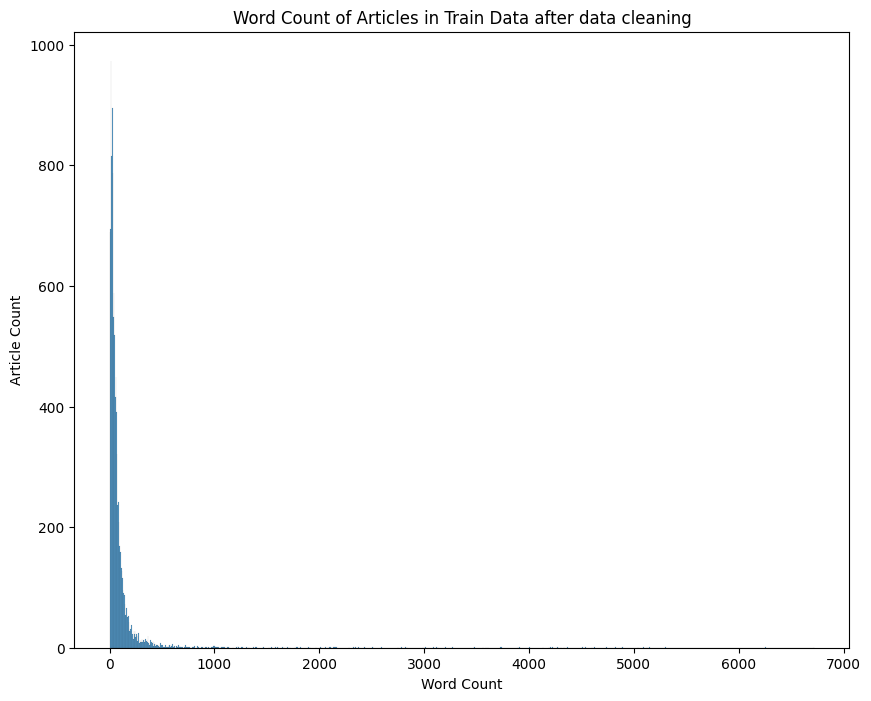

In [13]:
df_train['word_count'] = df_train['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count of Articles in Train Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [14]:
#Referring plot we estimate most of the articles have less than 300 words
train_articles = (sum(df_train['word_count'] < 400)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 400 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 400 Words:96.83%


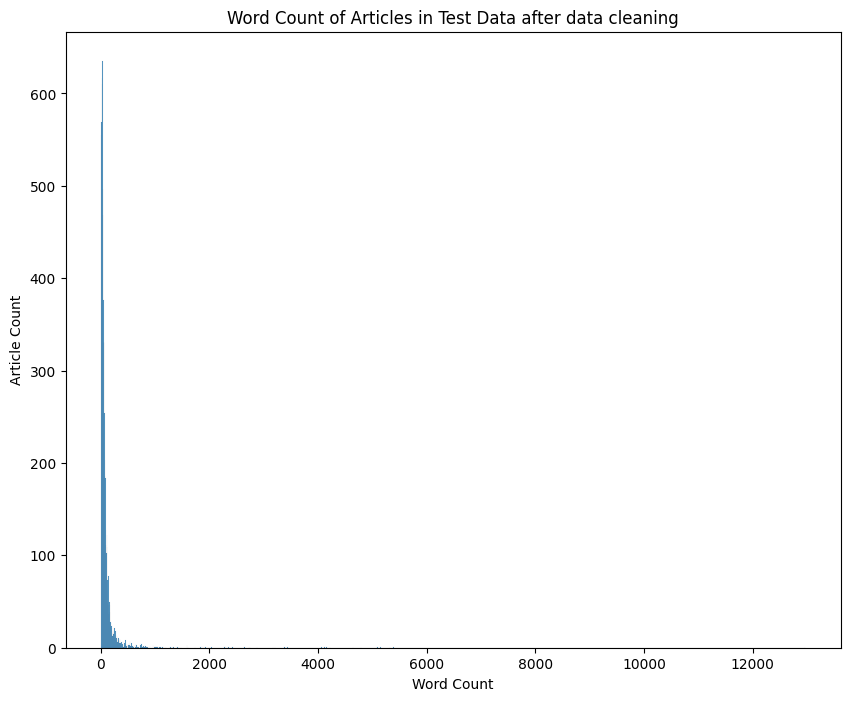

In [15]:
df_test['word_count'] = df_test['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count of Articles in Test Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [16]:
test_articles = (sum(df_test['word_count'] < 400)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 400 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 400 Words:97.15%


In [12]:
X_train = df_train['article']
y_train = df_train['label']
X_test = df_test['article']
y_test = df_test['label']

**Feature Extraction - Different Embeddings and Comparison**

Word embedding is the number representation of a text. There may be different numerical representations of the same text and hence different kinds of word embeddings.

Many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. And with the huge amount of data that is present in the text format, it is imperative to extract knowledge out of it and build applications.Hence arise the need of word embedding.

A Word Embedding format generally tries to map a word using a dictionary to a vector.

We will be using prediction based word embeddings which are based on probabilities of words and also perform word analogies and word similarities

**Word2Vec Embedding**

Word2vec embedding is combination of techniques CBOW(Continuous Bag of Words) and Skip - Gram Model.Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

We will be training our own word2vec on a custom corpus. For training the model we will be using gensim and the steps are illustrated as below.

word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that documents.

In [13]:
#Create a list of sentences, where each sentence is a list of preprocessed words from the dataset.This is also reffered as corpus
print("Example of a list of words from a sentence:",X_train[0].split())

sentences = X_train.str.split().tolist()

Example of a list of words from a sentence: ['wonder', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', '2door', 'sport', 'car', 'look', 'late', '60', 'early', '70', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatever', 'info', 'funky', 'look', 'car', 'please', 'email']


In [14]:
# #Create a list of sentences, where each sentence is a list of preprocessed words from the dataset.This is also reffered as corpus

sentences = X_train.str.split().tolist()


#Initialize and train the Word2Vec model on the preprocessed corpus.

model_word2vec = Word2Vec(sentences, min_count=1, vector_size=300, workers=4)

In [15]:
#explore model
#use the trained Word2Vec model to compute word similarities or perform analogy tasks.


word_vector = model_word2vec.wv['car']
similar_words_word2vec = model_word2vec.wv.most_similar(word_vector)

similar_words_word2vec

[('car', 1.0),
 ('bike', 0.9779655933380127),
 ('ridden', 0.9580094814300537),
 ('tire', 0.9537659883499146),
 ('around', 0.944083571434021),
 ('big', 0.9401063323020935),
 ('pivot', 0.9399263858795166),
 ('spaghetti', 0.9373284578323364),
 ('buy', 0.9364936351776123),
 ('shelf', 0.9331061244010925)]

**Glove Embedding**

The GloVe algorithm aims to learn word embeddings by considering the global word co-occurrence statistics from a corpus.

Both Word2Vec and GloVe embeddings provide dense vector representations for words, capturing semantic relationships. However, the training processes and underlying methodologies differ. Word2Vec employs either the continuous bag-of-words (CBOW) or skip-gram algorithm, while GloVe focuses on word co-occurrence statistics.

We will use the Keras tokenizer from the text preprocessing library i.e., keras.preprocessing.text.Tokenizer(). Essentially, the Keras tokenizer processes all the individual tokens in the dataset articles and then assigns an ID to each unique token in the form of a dictionary.

During initialization, we need to define num_words which specifies the number of most frequent words to be used in the tokenizer vocabulary:

The word embeddings of our dataset can be learned while training a neural network on the classification problem. Before it can be presented to the network, the text data is first encoded so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API provided with Keras. We add padding to make all the vectors of same length (max_length). Below code converts the text to integer indexes, now ready to be used in Keras embedding layer.

In [16]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

In [17]:
#total vocabulary size for our training data:

vocab_size = len(tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 115662


In [18]:
#convert each article into our training/testing data such that each tokenized word is replaced by its mathematical index as represented in the tokenizer.index_word:

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [19]:
#explore a sample before and after tokenization
print(X_train[0])
print("Total Words:", len(str(X_train[0]).split()))

wonder anyone could enlighten car saw day 2door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email
Total Words: 45


In [20]:
print(X_train_token[0])
print("Text Sequence Length:", len(X_train_token[0]))

[465, 54, 18, 5484, 114, 449, 71, 21093, 1192, 114, 29, 457, 8359, 483, 7174, 44, 26930, 808, 65, 209, 785, 620, 5025, 985, 510, 361, 7, 54, 41371, 299, 94, 605, 1911, 21, 1948, 114, 8, 365, 561, 265, 15167, 29, 114, 59, 84]
Text Sequence Length: 45


In [26]:
# we need to pad or truncate the encoded sequences into fixed-length vectors irrespective of the word length in each article.

#we will post-pad these sequences to a maximum length of 400.

sequence_len = 400
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)
print("First Instance Text Sequence:\n")
print(X_train_token[0])
print("\nFirst Instance Text Sequence Length:", len(X_train_token[0]))

First Instance Text Sequence:

[  465    54    18  5484   114   449    71 21093  1192   114    29   457
  8359   483  7174    44 26930   808    65   209   785   620  5025   985
   510   361     7    54 41371   299    94   605  1911    21  1948   114
     8   365   561   265 15167    29   114    59    84     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

In [27]:

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf-8") as file:
        for line in file:
            #print(line)
            line = line.strip()  # Remove leading/trailing whitespaces
            if line:
                parts = line.split()
                if len(parts) < embedding_dim + 1:
                    continue  # Skip lines that don't have enough values
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                if word in word_index:
                    idx = word_index[word]
                    embedding_matrix[idx] = vector[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
glove_embedding_filepath = "/content/sample_data/glove.6B.100d.txt"
embedding_matrix = create_embedding_matrix(glove_embedding_filepath, tokenizer.word_index, embedding_dim)
print(embedding_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**BERT Embedding**

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model introduced by Google in 2018. BERT is designed to generate contextualized word embeddings, which capture the meaning of words based on their surrounding context in a given sentence or text.

The BERT model is pretrained on large amounts of text data in an unsupervised manner. During this pretraining phase, BERT learns to predict missing words in sentences by considering the context of the surrounding words. This process allows BERT to capture the semantic relationships between words and produce meaningful representations.

BERT embeddings, also known as BERT vectors or BERT representations, are dense, fixed-length numerical representations that encode the contextual meaning of words. These embeddings can be used as input features for various natural language processing (NLP) tasks such as text classification, named entity recognition, sentiment analysis, and question answering.

The power of BERT embeddings lies in their ability to capture the nuances of language and the context in which words are used. By using BERT embeddings, NLP models can leverage the pretrained knowledge and context-awareness of BERT to enhance their performance on a wide range of NLP tasks. BERT embeddings have become popular and widely used in the NLP community due to their effectiveness in capturing the semantic information of words and sentences.

In [28]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00


In [29]:
from transformers import BertTokenizer, BertModel,TFBertModel


# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training dataset
train_encodings = tokenizer(df_train['article'][:1000].tolist(), truncation=True, padding=True, max_length=128)
#print(train_encodings)

# Tokenize and encode the test dataset
test_encodings = tokenizer(df_test['article'][:1000].tolist(), truncation=True, padding=True, max_length=128)
#print(test_encodings)

In [30]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

# Preprocess the data
max_length = 50  # Maximum sequence length, due system limitation
X_train = df_train['article'].values
y_train = df_train['label'].values
X_test = df_test['article'].values
y_test = df_test['label'].values

# Tokenize and encode the input sequences
X_train_encoded = tokenizer.batch_encode_plus(
    X_train,
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf'
)

X_test_encoded = tokenizer.batch_encode_plus(
    X_test,
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf'
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Get BERT embeddings
X_train_embeddings = model.predict([X_train_encoded['input_ids'], X_train_encoded['attention_mask']])
print(X_train_embeddings.last_hidden_state)
X_test_embeddings = model.predict([X_test_encoded['input_ids'], X_test_encoded['attention_mask']])
#print(X_test_embeddings)

# Reshape the embeddings for compatibility with classifiers
X_train_embeddings = np.array(X_train_embeddings.last_hidden_state)[:, 0, :]

X_test_embeddings = np.array(X_test_embeddings.last_hidden_state)[:, 0, :]
#print(X_train_embeddings)

354/354 [==============================] - 1865s 5s/step
[[[ 0.01773422  0.2394377   0.31624174 ... -0.49523222  0.27055913
   -0.06574426]
  [ 1.2503889   0.7147877   0.8471421  ... -0.4876123   0.59645945
   -0.683615  ]
  [-0.31871969  0.24075605  0.4555317  ... -0.03915391 -0.00459672
   -0.5583638 ]
  ...
  [-0.03690768  0.43333155  0.75794065 ... -0.5995133   0.04579444
   -0.27240297]
  [-0.05398957  0.7590048   0.5230497  ... -0.7681844  -0.12458444
   -0.37474492]
  [ 0.5479066   0.2826706  -0.14013037 ... -0.00506602 -0.3396699
   -0.22720906]]

 [[-0.4889018  -0.27052188  0.17369013 ... -0.22493751  0.13211012
    0.11195996]
  [-0.08052783 -0.27429348  0.7618418  ... -0.27751946  0.34925756
   -0.02271587]
  [ 0.0055091  -0.7648631   0.7456746  ...  0.05159764  0.22025068
    0.60366106]
  ...
  [-0.6158258  -0.74396014  0.41801757 ... -0.04798111  0.19118446
   -0.64755815]
  [-0.40360555 -0.718751   -0.17946157 ...  0.40629452  0.28697485
   -0.42906496]
  [ 0.7523765  -0

In [ ]:
from sklearn.preprocessing import MinMaxScaler #fixed import
from sklearn.ensemble import RandomForestClassifier

scaler = MinMaxScaler()
X_train_embeddings = scaler.fit_transform(X_train_embeddings)
#X_test = scaler.transform(X_test)

# # Initialize and train the classifiers
# svm = SVC()
# svm.fit(X_train_embeddings, y_train)

# mnb = MultinomialNB()
# mnb.fit(X_train_embeddings, y_train)

rf = RandomForestClassifier()
rf.fit(X_train_embeddings, y_train)

# Predict on the test set
# y_pred_svm = svm.predict(X_test_embeddings)
# y_pred_mnb = mnb.predict(X_test_embeddings)
y_pred_rf = rf.predict(X_test_embeddings)

# Calculate accuracies
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# print("SVM Accuracy:", accuracy_svm)
# print("MNB Accuracy:", accuracy_mnb)
print("RF Accuracy:", accuracy_rf)

RF Accuracy: 0.09532660647902283


## Comparison of word2vec, GloVe, and BERT embeddings
### Discussion on the embeddings that provide better semantic understanding

Word2Vec, GloVe, and BERT are all popular methods used for generating word embeddings, but they differ in their approaches and the level of semantic understanding they provide. Here is a comparison in terms of their underlying methodologies and their semantic understanding capabilities.

### Word2Vec:

Word2Vec is a shallow neural network-based approach for generating word embeddings. It has two main models: Continuous Bag of Words (CBOW) and Skip-gram. Word2Vec captures word co-occurrence patterns in a large corpus to learn vector representations that encode semantic and syntactic similarities between words. The resulting embeddings are effective for capturing word-level relationships, such as analogies (e.g., "king" - "man" + "woman" ≈ "queen").
However, Word2Vec has limitations when it comes to understanding complex semantic relationships. It does not consider contextual information, resulting in a lack of sensitivity to word meaning variations across different contexts.

### GloVe:
Global Vectors for Word Representation (GloVe) is a model that combines the advantages of Word2Vec and matrix factorization techniques. It leverages co-occurrence statistics to capture both local and global word relationships. GloVe embeddings are generated by factorizing a word co-occurrence matrix to obtain vector representations that encode semantic meaning.
GloVe embeddings excel at capturing global semantic relationships between words. They provide better results for tasks like word analogy and word similarity. GloVe also mitigates some of the weaknesses of Word2Vec by considering the global context of word occurrences. However, like Word2Vec, GloVe does not capture fine-grained contextual information.

### BERT:
Bidirectional Encoder Representations from Transformers (BERT) is a deep transformer-based model that revolutionized natural language processing. Unlike Word2Vec and GloVe, BERT is a contextually aware language model that learns word embeddings while considering the surrounding context. It uses a masked language model and a next sentence prediction task during pre-training to generate embeddings that capture rich semantic and contextual information.
BERT embeddings provide a deeper understanding of semantic relationships as they capture context-specific meanings. This enables BERT to perform well on various downstream tasks, such as named entity recognition, sentiment analysis, and question answering. BERT's ability to consider bidirectional context gives it an advantage over Word2Vec and GloVe for capturing more nuanced semantic nuances.

In terms of semantic understanding, BERT embeddings generally outperform Word2Vec and GloVe due to their contextual awareness. They excel in capturing fine-grained relationships and nuances between words. However, it's worth noting that BERT models are computationally expensive and require substantial resources for training and inference, which may limit their applicability in certain scenarios.

Overall, while Word2Vec and GloVe are effective for capturing word-level relationships, BERT embeddings provide better semantic understanding by considering contextual information, making them more suitable for a wide range of natural language processing tasks

**Part 2: Text Classification Model (20 Points)**

Correct implementation of chosen classification model

Comprehensive discussion on the choice of model, including its advantages and disadvantages

We are now ready to define our neural network model. The model will use an Embedding layer as the first hidden layer. The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset during training of the model.

**Text Classification Using CNN Model**

To use CNN for text classification, we will use the Sequential() model in Tensorflow Keras and add the layers into this model one by one.

In [31]:
model = Sequential()

**Use embedding matrix generated from glove embedding**

Initialize the weights of the Embedding layer with the embedding matrix. Secondly, we will need to assign trainable=True so that model weights are fine-tuned as per the news categories in the training data:

In [32]:
embedding_dim = 100
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_len, weights = [embedding_matrix], trainable = True))


In [33]:
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPool1D())

To complete the model, we will add fully connected hidden network layers with ‘relu’ activation and an output layer having the same no. of neurons as that of the news categories (20) with ‘softmax’ activation:

In [34]:
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

Now we can compile the model by defining the optimization and loss calculation algorithms:

In [35]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          11566200  
                                                                 
 conv1d (Conv1D)             (None, 396, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                        

Now we can fit the CNN model for text classification using the training dataset, whereas the validation dataset will be used to calculate the validation loss/accuracy during training:

In [36]:
history = model.fit(X_train_token, y_train, epochs=20, validation_data=(X_test_token, y_test), batch_size=128)

Epoch 1/20
89/89 [==============================] - 89s 966ms/step - loss: 2.9951 - accuracy: 0.0491 - val_loss: 2.9941 - val_accuracy: 0.0530
Epoch 2/20
89/89 [==============================] - 88s 996ms/step - loss: 2.9936 - accuracy: 0.0530 - val_loss: 2.9928 - val_accuracy: 0.0530
Epoch 3/20
89/89 [==============================] - 94s 1s/step - loss: 2.9926 - accuracy: 0.0492 - val_loss: 2.9921 - val_accuracy: 0.0530
Epoch 4/20
89/89 [==============================] - 97s 1s/step - loss: 2.9919 - accuracy: 0.0530 - val_loss: 2.9915 - val_accuracy: 0.0530
Epoch 5/20
89/89 [==============================] - 93s 1s/step - loss: 2.9914 - accuracy: 0.0530 - val_loss: 2.9911 - val_accuracy: 0.0530
Epoch 6/20
89/89 [==============================] - 100s 1s/step - loss: 2.9911 - accuracy: 0.0506 - val_loss: 2.9908 - val_accuracy: 0.0528
Epoch 7/20
89/89 [==============================] - 89s 998ms/step - loss: 2.9909 - accuracy: 0.0525 - val_loss: 2.9907 - val_accuracy: 0.0530
Epoch 8/20

Because of limited computing resources, it is restricted the training to only 20 epochs

In [37]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  accuracy  val_loss  val_accuracy
0   2.995071  0.049143  2.994066      0.052974
1   2.993587  0.053032  2.992849      0.052974
2   2.992586  0.049231  2.992066      0.052974
3   2.991887  0.053032  2.991468      0.052974
4   2.991445  0.053032  2.991104      0.052974
5   2.991080  0.050645  2.990836      0.052841
6   2.990862  0.052501  2.990657      0.052974
7   2.990722  0.050645  2.990520      0.052841
8   2.990615  0.050292  2.990454      0.052974
9   2.990549  0.052059  2.990375      0.052974
10  2.990514  0.050645  2.990340      0.052841
11  2.990474  0.051087  2.990324      0.052974
12  2.990445  0.049408  2.990311      0.052974
13  2.990430  0.051264  2.990293      0.052974
14  2.990433  0.049938  2.990290      0.052974
15  2.990425  0.051529  2.990281      0.052974
16  2.990420  0.053032  2.990274      0.052974
17  2.990424  0.051617  2.990270      0.052974
18  2.990438  0.049850  2.990271      0.052841
19  2.990426  0.050822  2.990269      0.052708


We can now plot the loss and accuracy for validation/testing datasets using matplotlib and get an idea of the model training:

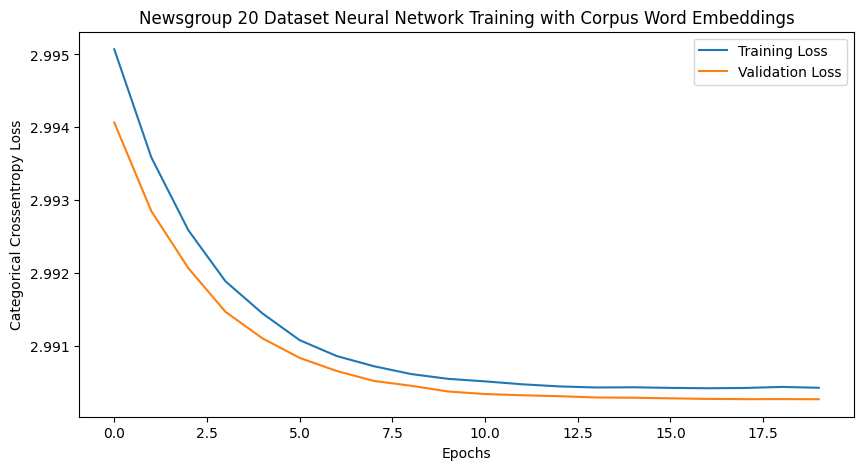

In [38]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Newsgroup 20 Dataset Neural Network Training with Corpus Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

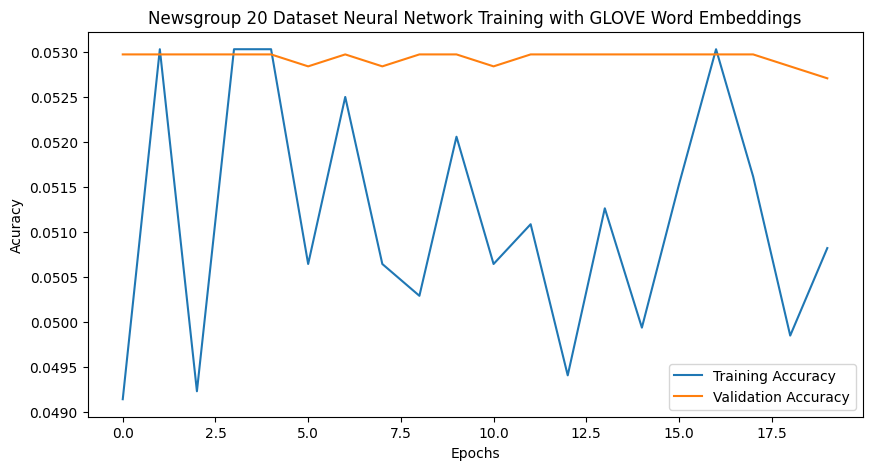

In [39]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Newsgroup 20 Dataset Neural Network Training with GLOVE Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

### Comprehensive discussion on the choice of model, including its advantages and disadvantages

#### Advantages of using a CNN model for text classification with a matrix generated from GloVe embeddings


These results could further be improved by training the models for larger epochs and using a GloVe embedding with more tokens and/or dimensions.

Using a Convolutional Neural Network (CNN) model for text classification with a matrix generated from GloVe embeddings offers several advantages. Let's discuss these advantages in detail:

Capturing Local Patterns: CNN models are well-suited for capturing local patterns within sequences, making them effective for text classification tasks. In the context of natural language processing, local patterns can be n-grams or word combinations that carry important information for classification. CNNs utilize convolutional layers to detect these patterns efficiently.

Parameter Sharing: CNNs leverage parameter sharing, meaning that the same set of weights is applied to different parts of the input. In the case of text classification, this allows the model to identify relevant features (e.g., important words or phrases) regardless of their position in the input text. Parameter sharing enables the model to learn from a larger number of training instances, leading to improved generalization and reduced overfitting.

Handling Variable-Length Inputs: Text data often has variable lengths, which can be challenging for traditional neural network architectures. However, CNN models can handle variable-length inputs through their ability to perform convolutions across different lengths. By using sliding windows of different sizes, CNNs can capture patterns at various granularities, effectively dealing with the variable-length nature of text.

Complementary GloVe Embeddings: GloVe embeddings, derived from co-occurrence statistics, provide vector representations that encode semantic meaning. By utilizing these pre-trained embeddings as input to the CNN model, the network can benefit from the semantic information encoded in the GloVe vectors. This can enhance the model's understanding of word relationships and improve its performance on downstream tasks.

Transfer Learning: CNN models with GloVe embeddings allow for transfer learning. GloVe embeddings are trained on large-scale corpora and capture general semantic information from text. By utilizing these pre-trained embeddings as a starting point, the CNN model can leverage the knowledge encoded in the GloVe vectors and adapt it to the specific classification task with a smaller dataset. This enables the model to achieve better performance even when the available training data is limited.

Despite their advantages, CNN models with GloVe embeddings also have some limitations:

Lack of Contextual Information: GloVe embeddings provide word-level representations but do not capture fine-grained contextual information. While they encode semantic relationships, they do not consider the specific context in which words appear. This can limit the model's understanding of subtle semantic nuances and dependencies that rely on context.

Inability to Capture Long-Range Dependencies: CNN models with fixed-size convolutions are limited in capturing long-range dependencies between words in a sentence. While they excel at detecting local patterns, they may struggle to capture relationships that span across a large distance within the text.

Vocabulary Limitations: GloVe embeddings are generated based on the words present in the training corpus. Therefore, out-of-vocabulary (OOV) words or rare words not seen during training may not have pre-existing embeddings. Handling OOV words and rare words becomes a challenge when using GloVe embeddings in a CNN model.

Computational Complexity: CNN models can be computationally intensive, especially if the input text is large or if the model architecture is complex. Training and inference may require significant computational resources and time.

In conclusion, utilizing a CNN model with a matrix generated from GloVe embeddings offers advantages such as capturing local patterns, parameter sharing, handling variable-length inputs, and leveraging transfer learning. However, it has limitations in terms of capturing contextual information, long-range dependencies, vocabulary limitations, and computational complexity. These factors should be carefully considered when choosing a model for text classification tasks.


## Part 3: Text Clustering Model (20 Points)


*  Correct implementation of chosen clustering model
*  Comprehensive discussion on the choice of model, including its pros and cons






In [40]:
print(sentences[1:5])

[['fair', 'number', 'brave', 'soul', 'upgrade', 'clock', 'oscillator', 'share', 'experience', 'poll', 'please', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'cpu', 'rat', 'speed', 'add', 'card', 'adapter', 'heat', 'sink', 'hour', 'usage', 'per', 'day', 'floppy', 'disk', 'functionality', '800', 'floppy', 'especially', 'request', 'summarize', 'next', 'two', 'day', 'please', 'add', 'network', 'knowledge', 'base', 'do', 'clock', 'upgrade', 'answer', 'poll', 'thanks'], ['well', 'folk', 'mac', 'plus', 'finally', 'give', 'ghost', 'weekend', 'start', 'life', '512k', 'way', 'back', '1985', 'sooo', 'market', 'new', 'machine', 'bit', 'sooner', 'intend', 'look', 'pick', 'powerbook', '160', 'maybe', '180', 'bunch', 'question', 'hopefully', 'somebody', 'answer', 'anybody', 'know', 'dirt', 'next', 'round', 'powerbook', 'introduction', 'expect', 'heard', '185c', 'suppose', 'make', 'appearence', 'summer', 'heard', 'anymore', 'since', 'access', 'macleak', 'w

In [22]:
import numpy as np


sentence_vectors = []
for sentence in sentences:
    word_vectors = [model_word2vec.wv[word] for word in sentence if word in model_word2vec.wv]
    if len(word_vectors) > 0:
        sentence_vector = np.mean(word_vectors, axis=0)  # Compute the mean of word vectors
        sentence_vectors.append(sentence_vector)

sentence_matrix = np.vstack(sentence_vectors)  # Convert the list of vectors to a matrix
print(sentence_matrix[1:5])

[[-0.09071023  0.02813848  0.28380197 ... -0.13747197 -0.09908128
   0.06942708]
 [-0.05525618  0.10118648  0.18876417 ... -0.11884667 -0.00735986
   0.07376757]
 [-0.00121032  0.06390781  0.25437918 ... -0.09296017  0.02712311
   0.24011175]
 [-0.07239241  0.10571804  0.2763223  ... -0.10511496  0.08149396
   0.15323909]]


In [42]:
from sklearn.cluster import KMeans

# Assuming you have sentence_matrix from previous steps

# Specify the number of clusters
num_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sentence_matrix)

# Get the cluster labels for each sentence
labels = kmeans.labels_

# Print the cluster labels
# for i, sentence in enumerate(sentences):
#     if i < len(labels):
#         print(f"Sentence: {sentence}")
#         print(f"Cluster label: {labels[i]}")
#         print()

# Access the cluster centers
cluster_centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


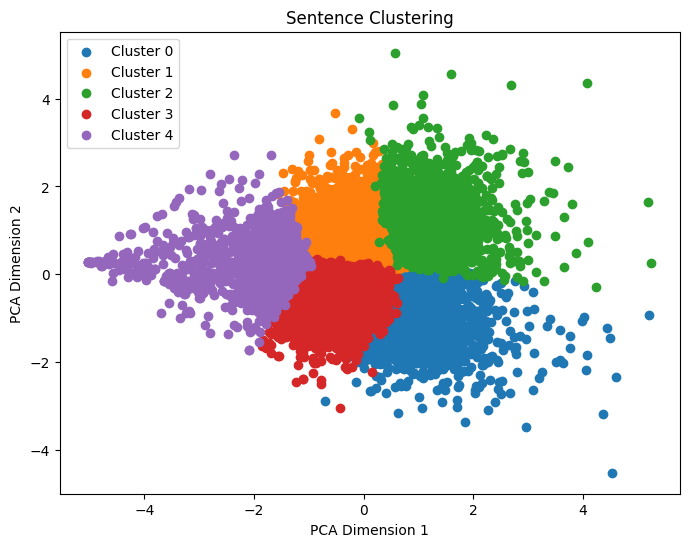

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have sentence_matrix and labels from previous steps

# Reduce the dimensionality using PCA
pca = PCA(n_components=2)
sentence_pca = pca.fit_transform(sentence_matrix)

# Create a scatter plot of the sentence representations with cluster labels
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_sentences = sentence_pca[labels == i]
    plt.scatter(cluster_sentences[:, 0], cluster_sentences[:, 1], label=f"Cluster {i}")

plt.title("Sentence Clustering")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()


**Choice of K-means:**
K-means is a popular clustering algorithm that partitions data into K clusters based on similarity. Although K-means is primarily designed for unsupervised clustering, it can be adapted for text classification by assigning labels to clusters based on majority voting or using cluster centroids as representative examples.

**Pros of using K-means for text classification:**

**Simplicity:** K-means is a straightforward and easy-to-implement algorithm, making it accessible for beginners.
Scalability: K-means is computationally efficient and can handle large datasets with a large number of features.

**Interpretability:** The resulting clusters can provide insights into the structure and organization of the dataset, enabling some level of interpretability.
Cons of using K-means for text classification:

**Lack of probabilistic inference:** K-means does not provide probabilistic inference for cluster assignments. It assigns each document to a single cluster, potentially disregarding uncertainty or overlapping boundaries between classes.

**Sensitivity to initialization:** K-means is sensitive to initial centroid selection, and different initializations can result in different cluster assignments. Multiple runs with different initializations may be needed to ensure robustness.

**Assumption of spherical clusters:** K-means assumes that clusters are spherical and have equal variance. In text classification, this assumption may not hold as documents within the same class can have varying distributions and shapes in the feature space.

**Difficulty in handling high-dimensional data:** Text data often has high dimensionality due to the large vocabulary. K-means may struggle to effectively cluster in high-dimensional spaces, leading to suboptimal results.

**Choice of PCA:**

Principal Component Analysis (PCA) is a dimensionality reduction technique used to reduce the number of features while preserving the most important information. PCA transforms the data into a lower-dimensional space by finding orthogonal directions (principal components) that capture the maximum variance.

**Pros of using PCA for dimensionality reduction:**

**Reduced computational complexity:** PCA reduces the dimensionality of the data, making subsequent computations more efficient.
Noise reduction: By eliminating less informative dimensions, PCA can reduce the impact of noisy or irrelevant features, leading to improved clustering performance.

**Visualization:** PCA can help visualize high-dimensional data in a lower-dimensional space, enabling better understanding of the data's structure.
Cons of using PCA for dimensionality reduction:

**Information loss:** PCA aims to retain the most important information, but it inevitably leads to some loss of detailed information in the original data.
Interpretability challenges: The resulting transformed features after PCA may not have a direct correspondence to the original features, making it harder to interpret the model's decision-making process.

In the context of text classification on the 20 Newsgroups dataset, using K-means with PCA has some limitations. K-means is not designed for supervised classification, and its performance heavily depends on the quality of the clustering and the representation of clusters. PCA reduces the dimensionality, but it may not capture all the intricate relationships present in the text data.

To mitigate these limitations, we can consider the following:

**Evaluation and refinement:** Proper evaluation metrics and validation techniques should be employed to assess the performance of the K-means model. Iterative refinement of hyperparameters, initialization strategies, and feature representations can help improve the results.

**Feature engineering:** Use more sophisticated text representations, such as TF-IDF, word embeddings (e.g., Word2Vec, GloVe), or contextual embeddings (e.g., BERT), which can provide better feature representations than simple bag-of-words.

**Ensemble methods:** Combine multiple clustering models





## 4. Part 4: Model Evaluation (20 Points)**



In [44]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  accuracy  val_loss  val_accuracy
0   2.995071  0.049143  2.994066      0.052974
1   2.993587  0.053032  2.992849      0.052974
2   2.992586  0.049231  2.992066      0.052974
3   2.991887  0.053032  2.991468      0.052974
4   2.991445  0.053032  2.991104      0.052974
5   2.991080  0.050645  2.990836      0.052841
6   2.990862  0.052501  2.990657      0.052974
7   2.990722  0.050645  2.990520      0.052841
8   2.990615  0.050292  2.990454      0.052974
9   2.990549  0.052059  2.990375      0.052974
10  2.990514  0.050645  2.990340      0.052841
11  2.990474  0.051087  2.990324      0.052974
12  2.990445  0.049408  2.990311      0.052974
13  2.990430  0.051264  2.990293      0.052974
14  2.990433  0.049938  2.990290      0.052974
15  2.990425  0.051529  2.990281      0.052974
16  2.990420  0.053032  2.990274      0.052974
17  2.990424  0.051617  2.990270      0.052974
18  2.990438  0.049850  2.990271      0.052841
19  2.990426  0.050822  2.990269      0.052708


When training a Convolutional Neural Network (CNN) for classification tasks, several loss and accuracy metrics are commonly used to evaluate the performance of the model. Here are some commonly used metrics:

**Loss Metrics:**

Cross-Entropy Loss: This is the most commonly used loss function for classification problems. It measures the dissimilarity between the predicted class probabilities and the true class labels.

Categorical Cross-Entropy Loss: Specifically used when dealing with multi-class classification problems, where each instance can only belong to one class.

Binary Cross-Entropy Loss: Used in binary classification problems, where each instance can belong to one of two classes.
Accuracy Metrics:

**Classification Accuracy:**

This is the simplest and most intuitive metric, representing the percentage of correctly classified instances out of the total.

Top-k Accuracy: Instead of considering only the top predicted class, this metric takes into account the top-k predicted classes and checks if the true class label is within those k predictions.

Precision, Recall, and F1-score: These metrics are commonly used when dealing with imbalanced datasets or when the focus is on a specific class. Precision measures the proportion of true positives out of the predicted positives, recall measures the proportion of true positives out of the actual positives, and F1-score is the harmonic mean of precision and recall.

These metrics are typically calculated during the training process to monitor the model's performance and make necessary adjustments. They help to evaluate the loss (how well the model is fitting the training data) and accuracy (how well the model is generalizing to unseen data) of the CNN classification model.

To evaluate the performance of K-means clustering, several metrics can be used. Here's an example Python code that demonstrates how to evaluate K-means clustering using three common metrics: silhouette score and inertia.

Incase of Text Clustering, we have following evaluation metrics as below:

In [25]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

# New Section

# Assuming you have sentence_matrix from previous steps

# Specify the number of clusters
num_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(sentence_matrix)

# Get the cluster labels for each sentence
labels = kmeans.labels_

# Silhouette score
silhouette_avg = metrics.silhouette_score(sentence_matrix, labels)
print("Silhouette Score:", silhouette_avg)

# Inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.16530924
Inertia: 20440.0390625


Silhouette Score: Measures how close each sample in one cluster is to the samples in the neighboring clusters. A higher silhouette score indicates better-defined clusters.

Inertia: The sum of squared distances of samples to their closest cluster center. Lower inertia values indicate better clustering.




## 5. Part 5: Model Improvement Discussion (20 Points)**

Comprehensive discussion on potential improvements, including handling unbalanced data, dealing with slang, abbreviations or typos, and addressing context and word disambiguation challenges

Improving a text classification model involves addressing various challenges such as handling unbalanced data, dealing with slang, abbreviations or typos, and addressing context and word disambiguation challenges. Here are some potential improvements for each of these aspects:

To further improve the CNN model for text classification using the provided 20 Newsgroups dataset, there are several potential improvements to consider. Let's discuss handling unbalanced data, dealing with slang/abbreviations/typos, and addressing context and word disambiguation challenges.

**Handling Unbalanced Data**

The 20 Newsgroups dataset may have class imbalances, where certain categories have significantly more instances than others. To address this, you can employ techniques such as:

Oversampling: Increase the representation of minority classes by duplicating or generating synthetic samples to balance the class distribution.

Undersampling: Reduce the representation of the majority class by randomly removing instances to achieve a balanced dataset.

Class weighting: Assign higher weights to the minority classes during training to prioritize their importance and adjust for the class imbalance.

**Dealing with Slang, Abbreviations, and Typos**:

The 20 Newsgroups dataset contains informal language, slang, abbreviations, and potential typos. To handle these challenges, you can consider the following approaches:

Preprocessing: Apply text normalization techniques like expanding contractions (e.g., "can't" to "cannot"), converting slang/abbreviations to their full forms (e.g., "lol" to "laugh out loud"), and correcting common typos.

Custom Word Embeddings: Train word embeddings specifically on the dataset, or utilize domain-specific pre-trained embeddings. These embeddings can capture the specific language patterns, including slang and abbreviations, improving the model's understanding of the data.

**Addressing Context and Word Disambiguation Challenges**:

The 20 Newsgroups dataset contains instances where words can have multiple meanings or require contextual understanding. Here are some strategies to address context and word disambiguation challenges:

Contextual Word Embeddings: Instead of using static word embeddings like GloVe, consider employing contextual word embeddings such as ELMo, GPT, or BERT. These models capture contextual information and can provide better representations for words based on their surrounding context.

Contextual Awareness in Architecture: Modify the CNN model to incorporate attention mechanisms or recurrent layers (e.g., LSTM or GRU) to capture and remember contextual information across the input text. These modifications can help the model better disambiguate words and understand their meanings in different contexts.

Named Entity Recognition (NER): Use NER techniques to identify and classify named entities in the text, as they can often carry important semantic information. This additional information can enhance the model's understanding of the context and improve classification accuracy.

It's important to note that the success of these improvements depends on the specific characteristics of the dataset and the complexity of the text classification task. Therefore, it's recommended to experiment with different techniques, evaluate their impact through proper validation methods, and iterate on the model and preprocessing steps to achieve the best results.